### 1 Import the modules firstly

In [6]:
import numpy as np
import os
import os,sys
import json
import random
import matplotlib.pyplot as plt
import math
import pandas as pd

### 2 Define some hyperparameter

In [2]:
MAX_LINK_NUM = 30

BASE_DIR = "/mnt/disk3/zihao/20220610data/InterRecon"
MOTION_DIR = "/mnt/disk3/zihao/20220610data/InterRecon/motion_split"
PCS_DIR = "/mnt/disk3/zihao/20220610data/InterRecon/pc_vscan_iter"

DATA_DIR = "/mnt/disk3/zihao/Action_Net/data"
SAVE_DIR = "/mnt/disk3/zihao/Action_Net/data/gen_score"

ALL_CATE_LIST = ['dishwasher','kitchenpot','microwave','oven','refrige','storage','table','trashcan']

SAMPLE_PER_PART = 100
COE_FRICTION = 0.2 
DEGREE_RANGE = 60

### 3 Define some useful function

In [3]:
def visual(pcs, pcs_seg=None, joint_list=None, save_path=None):
    x = pcs[:, 0]  
    y = pcs[:, 1]  
    z = pcs[:, 2]  
    fig = plt.figure()
    ax = fig.add_subplot(111, projection = '3d')
    ax.axis([0.0,1.0,0.0,1.0])
    origin = [0], [0], [0]
    ax.quiver(*origin, [1], [0], [0], color='r', length=0.5, arrow_length_ratio=0.1)
    ax.quiver(*origin, [0], [1], [0], color='g', length=0.5, arrow_length_ratio=0.1)
    ax.quiver(*origin, [0], [0], [1], color='b', length=0.5, arrow_length_ratio=0.1)
    if pcs_seg is not None:
        ax.scatter(z,x,y,c=pcs_seg)
    else:
        ax.scatter(z,x,y, c=y)
    if joint_list is not None:
        for joint in joint_list:
            ax.quiver(joint[2],joint[0],joint[1],joint[2+3],joint[0+3],joint[1+3],color='r', length=0.6)    
    if save_path is not None:
        plt.savefig(save_path)
    else:
        plt.show()
    plt.close()

### 4 Core function

In [10]:
def generate_vector(u):
    if np.linalg.norm(u) == 0:
        print("what")
    # Normalize the vector
    u = u / np.linalg.norm(u)

    # Generate two orthogonal vectors
    v1 = np.cross(u, np.array([1, 0, 0]))
    if np.linalg.norm(v1) < 1e-6:
        v1 = np.cross(u, np.array([0, 1, 0]))
    v1 = v1 / np.linalg.norm(v1)
    v2 = np.cross(u, v1)

    # Choose random angles
    degree_val = np.pi * DEGREE_RANGE / 360
    theta = np.random.uniform(-degree_val, degree_val)
    phi = np.random.uniform(0, 2*np.pi)

    # Compute the new vector
    v = np.cos(theta) * u + np.sin(theta) * \
        (np.cos(phi) * v1 + np.sin(phi) * v2)

    return v


def get_probs(d_list):
    di = [[d,i] for i, d in enumerate(d_list)]
    di = sorted(di, key=lambda x:x[0])
    
    n = len(di)
    n1 = int(n/3)
    n2 = n - 2*n1

    probs = [0 for i in range(n)]

    for i in range(n1):
        probs[i] = 0.3 / n1
        probs[i+n1] = 0.1 / n1 
    for i in range(n2): 
        probs[2*n1+i] = 0.6/n2

    rp = [0 for i in range(n)]
    for i in range(n):
        rp[di[i][1]] = probs[i]

    return rp 


def random_rotate_mat(theta=None, axis=[0, 1, 0], origin=[0.5, 0.5, 0.5]):
    if theta == None:
        theta = np.random.uniform(0, 2 * math.pi)
    origin = np.array(origin)
    cos_a = np.cos(theta)
    sin_a = np.sin(theta)
    rotate_mat = np.eye(4)
    rotate_mat[:3,:3] = np.array([[cos_a, 0, sin_a],
                                    [0, 1, 0],
                                    [-sin_a, 0, cos_a]])
    move_mat = np.eye(4)
    move_mat[:3, 3] = -origin
    move_back_mat = np.eye(4)
    move_back_mat[:3, 3] = origin
    
    return move_back_mat @ rotate_mat @ move_mat


def test_generate_vector():
    pcs = np.loadtxt("./demo_files/complete_ok.pts")
    index = random.randint(0, len(pcs))
    gen_vector = generate_vector(pcs[index][3:6])
    line1 = pcs[index][:6]
    line2 = np.concatenate([pcs[index][:3], gen_vector])
    visual(pcs, joint_list=[line2])
    for i in range(5):
        rotate_mat = random_rotate_mat(theta=0.05 * (i + 1) * math.pi)
        one_col = np.ones((pcs.shape[0],1))
        rotated_pcs = np.dot(np.concatenate([pcs[:, :3],one_col], axis=1), rotate_mat.T)[:, :3]
        one_col = np.ones((1,1))
        gen_vector0 = np.concatenate([np.array([gen_vector]),one_col],axis=1)
        rotated_gen_vector = np.dot(gen_vector0, rotate_mat.T)[0,:3]
        line3 = np.concatenate([rotated_pcs[index], rotated_gen_vector])
        visual(rotated_pcs,joint_list=[line3])

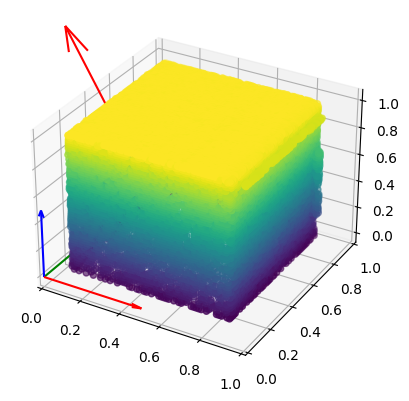

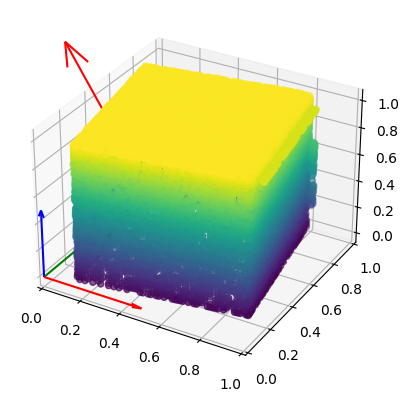

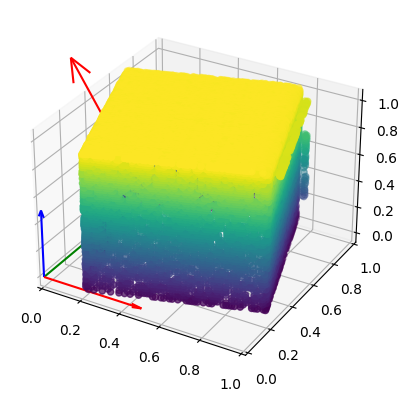

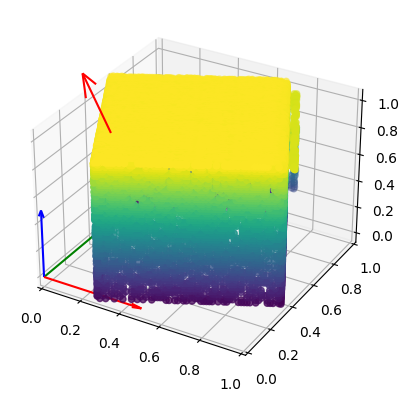

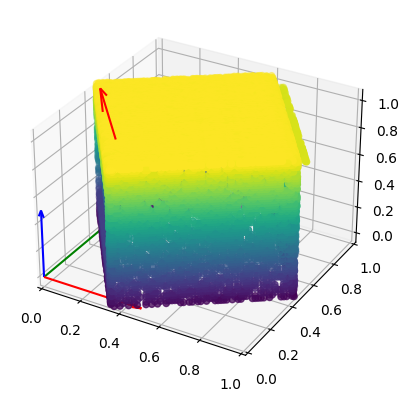

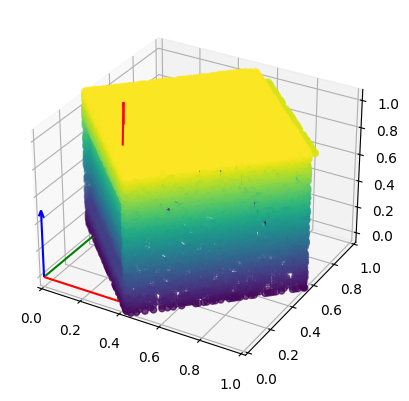

In [11]:
test_generate_vector()

In [7]:
def get_probs(d_list):
    di = [[d,i] for i, d in enumerate(d_list)]
    di = sorted(di, key=lambda x:x[0])
    
    n = len(di)
    n1 = int(n/3)
    n2 = n - 2*n1

    probs = [0 for i in range(n)]

    for i in range(n1):
        probs[i] = 0.3 / n1
        probs[i+n1] = 0.1 / n1 
    for i in range(n2): 
        probs[2*n1+i] = 0.6/n2

    rp = [0 for i in range(n)]
    for i in range(n):
        rp[di[i][1]] = probs[i]

    return rp 

def test_get_probs(n=1000):
    d_list = [random.randint(0, 10000) for _ in range(n)]
    probs = get_probs(d_list)
    print(f"Sum of probs: {sum(probs)}")

In [8]:
test_get_probs()

Sum of probs: 0.9999999999999988


### Work

In [29]:
def work(cate='storage', file_name='46452_s00_p00_f00', sample_per_part=SAMPLE_PER_PART, coe_friction=COE_FRICTION):
    shape_id, sid, pid, fid = file_name.split("_") # 46452 s00 p00 f00
    # use files :
    pc_pts_path = f"{PCS_DIR}/{cate}/{file_name}/complete_ok.pts"
    motion_json_path = f"{MOTION_DIR}/{cate}/{shape_id}_{sid}.json" 
    # save in :
    save_path = f"{SAVE_DIR}/{cate}/{file_name}.csv"
    # load motion 
    json_fp = open(motion_json_path, "r")
    info = json.load(json_fp)
    json_fp.close()
    # load point clouds
    pcs = np.loadtxt(pc_pts_path).astype(np.float32) # (16384, 7) :px py pz nx ny nz part_id
    
    # split the indice by part_id
    # part_num = info['partnum']
    part_num = int(np.max(pcs[:,-1])) + 1
    refpart = info['refpart']
    idmap = info['idmap']
    valid = info['valid']
    indices = [[] for i in range(part_num)]
    for i in range(len(pcs)):
        indices[int(pcs[i][-1])].append(i)
    # get the average normal of the part.
    average_normal = [[0,0,0] for i in range(part_num)]
    part_point_num = [0 for i in range(part_num)]
    for item in pcs:
        part_point_num[int(item[-1])] += 1
        for i in range(3):
            average_normal[int(item[-1])][i] += item[3+i]
    for part_id in range(part_num):
        if part_point_num[part_id] != 0:
            for i in range(3):
                average_normal[part_id][i] /= part_point_num[part_id]

    # gen_data
    gen_data = [[] for i in range(part_num)]
    for i in range(part_num):
        if np.linalg.norm(average_normal[i]) == 0:
            continue
        if i == refpart:
            used_indices = random.choices(indices[i],k=sample_per_part)
            for index in used_indices:
                p = pcs[index][:3]
                v = generate_vector(average_normal[i])
                gen_data[i].append([p[0],p[1],p[2],v[0],v[1],v[2],0])
        elif str(i) in idmap.keys() and valid[idmap[str(i)]] == 1 :
            axispos = info['axispos'][idmap[str(i)]]
            axisdir = info['axisdir'][idmap[str(i)]]
            if str(i) in idmap.keys() and info['type'][idmap[str(i)]] == 0:
                d_list = []
                for index in indices[i]:
                    p = pcs[index][:3]
                    v = generate_vector(average_normal[i])
                    d = np.linalg.norm(np.cross(p-axispos,axisdir))
                    d_list.append(d)
                    cos_va = np.dot(v,axisdir)
                    sin_va = np.sqrt(1-cos_va**2)
                    # * core rule
                    score = sin_va * d - coe_friction * cos_va
                    gen_data[i].append([p[0],p[1],p[2],v[0],v[1],v[2], score])
                assert len(d_list) != 0
                used_indices = random.choices([t for t in range(len(indices[i]))], get_probs(d_list), k=sample_per_part*10)
                tmp_data = []
                for index in used_indices:
                    tmp_data.append(gen_data[i][index]) 
                tmp_arr = np.array(tmp_data)
                min_val = min(tmp_arr[:,-1])
                max_val = max(tmp_arr[:,-1])
                tmp_arr[:,-1] = (tmp_arr[:,-1] - min_val) / (max_val - min_val)
                gen_data[i] = tmp_arr.tolist()
            else:
                used_indices = random.choices(indices[i], k=sample_per_part*10)
                for index in used_indices:
                    p = pcs[index][:3]
                    v = generate_vector(average_normal[i])
                    cos_va = np.dot(v,axisdir)
                    sin_va = np.sqrt(1-cos_va**2)
                    # * core rule
                    score = cos_va - coe_friction * sin_va
                    gen_data[i].append([p[0],p[1],p[2],v[0],v[1],v[2],score])
                tmp_arr = np.array(gen_data[i])
                min_val = min(tmp_arr[:,-1])
                max_val = max(tmp_arr[:,-1])
                tmp_arr[:,-1] = (tmp_arr[:,-1] - min_val) / (max_val - min_val)
                gen_data[i] = tmp_arr.tolist()
    all_gen_data = sum(gen_data, [])
    for i in range(len(all_gen_data)):
        all_gen_data[i].append(cate)
        all_gen_data[i].append(file_name)
    df = pd.DataFrame(all_gen_data)
    df.to_csv(save_path, index=False, header=False)


invalid:  3
invalid:  4
invalid:  5
invalid:  6
invalid:  7
invalid:  8
invalid:  9
invalid:  10
invalid:  11


In [17]:
xxp = [1,2,3,4,5,6]
uuu = [1,1,0,0,0,1]

In [19]:
uuu

[1, 0, 0, 0, 1]